In [14]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

In [16]:
df = pd.read_csv("~\\kaggle\\input\\edgeiiotset-cyber-security-dataset-of-iot-iiot\\Edge-IIoTset dataset\Selected dataset for ML and DL\\DNN-EdgeIIoT-dataset.csv", low_memory = False)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\aadit\AppData\Local\Temp\ipykernel_15560\3834739954.py:1: SyntaxWarning: invalid escape sequence '\S'
  df = pd.read_csv("~\\kaggle\\input\\edgeiiotset-cyber-security-dataset-of-iot-iiot\\Edge-IIoTset dataset\Selected dataset for ML and DL\\DNN-EdgeIIoT-dataset.csv", low_memory = False)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219201 entries, 0 to 2219200
Data columns (total 63 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   frame.time                 object 
 1   ip.src_host                object 
 2   ip.dst_host                object 
 3   arp.dst.proto_ipv4         object 
 4   arp.opcode                 float64
 5   arp.hw.size                float64
 6   arp.src.proto_ipv4         object 
 7   icmp.checksum              float64
 8   icmp.seq_le                float64
 9   icmp.transmit_timestamp    float64
 10  icmp.unused                float64
 11  http.file_data             object 
 12  http.content_length        float64
 13  http.request.uri.query     object 
 14  http.request.method        object 
 15  http.referer               object 
 16  http.request.full_uri      object 
 17  http.request.version       object 
 18  http.response              float64
 19  http.tls_port              float64
 20  tc

In [18]:
print(df['Attack_type'].value_counts())

Attack_type
Normal                   1615643
DDoS_UDP                  121568
DDoS_ICMP                 116436
SQL_injection              51203
Password                   50153
Vulnerability_scanner      50110
DDoS_TCP                   50062
DDoS_HTTP                  49911
Uploading                  37634
Backdoor                   24862
Port_Scanning              22564
XSS                        15915
Ransomware                 10925
MITM                        1214
Fingerprinting              1001
Name: count, dtype: int64


In [19]:
# Creating a dictionary of Types
attacks = {'Normal': 0,'MITM': 1, 'Uploading': 2, 'Ransomware': 3, 'SQL_injection': 4,
       'DDoS_HTTP': 5, 'DDoS_TCP': 6, 'Password': 7, 'Port_Scanning': 8,
       'Vulnerability_scanner': 9, 'Backdoor': 10, 'XSS': 11, 'Fingerprinting': 12,
       'DDoS_UDP': 13, 'DDoS_ICMP': 14}
df['Attack_type'] = df['Attack_type'].map(attacks)

In [20]:
X = df.drop(columns=['Attack_label', 'Attack_type'])
y = df['Attack_type']

In [21]:
# Apply the Chi-Squared test
X = X.select_dtypes(include=[np.number])
chi_selector = SelectKBest(chi2, k='all')  # Set k to the desired number of features
X_kbest = chi_selector.fit_transform(X, y)

In [22]:
# Get the scores for each feature
chi_scores = chi_selector.scores_

# Combine scores with feature names
chi_scores = pd.DataFrame({'feature': X.columns, 'score': chi_scores})

# Sort the features by their scores
chi_scores = chi_scores.sort_values(by='score', ascending=False)

print(chi_scores)

                      feature         score
9                     tcp.ack  1.034062e+15
10                tcp.ack_raw  4.586228e+14
4     icmp.transmit_timestamp  1.415100e+13
20                    tcp.seq  7.142197e+12
22                 udp.stream  2.755158e+12
24               dns.qry.name  2.823675e+11
2               icmp.checksum  6.883939e+10
3                 icmp.seq_le  6.265515e+10
16                tcp.dstport  9.144755e+09
11               tcp.checksum  7.803416e+09
19                    tcp.len  2.900511e+08
6         http.content_length  2.276928e+08
25                 dns.qry.qu  1.697608e+08
21                   udp.port  2.375369e+07
32              mqtt.hdrflags  9.924011e+06
17                  tcp.flags  4.251447e+06
23             udp.time_delta  4.111967e+06
33                   mqtt.len  1.643743e+06
37             mqtt.topic_len  7.442977e+05
7               http.response  6.247540e+05
35               mqtt.msgtype  6.202507e+05
1                 arp.hw.size  3

In [23]:
selected_features = chi_scores['feature'].tolist()[:93]  # Select top k features

In [24]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Split the training data further into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [25]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1553440, 42)
X_val shape: (221920, 42)
X_test shape: (443841, 42)


In [26]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [27]:
def cnn_lstm_bilstm_model(input_shape, num_classes):
    
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),        
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        LSTM(64, return_sequences=True),
        Bidirectional(LSTM(64, return_sequences=False)),
        
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
input_shape = (X_train.shape[1], 1)
num_classes = 15
model = cnn_lstm_bilstm_model(input_shape, num_classes)
model.summary()
plot_model(model)

c:\Users\aadit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 9, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,855 (483.81 KB)

 Trainable params: 123,855 (483.81 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [29]:
train_start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
# Record the ending time
train_end_time = time.time()

# Record the starting time for testing
test_start_time = time.time()
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
# Record the ending time for testing
test_end_time = time.time()

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time = train_end_time - train_start_time
print(f"Training time: {train_time:.2f} seconds")

# Calculate and print the testing time
test_time = test_end_time - test_start_time
print(f"Testing time: {test_time:.2f} seconds")

Epoch 1/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 17504s 360ms/step - accuracy: 0.9090 - loss: 0.3295 - val_accuracy: 0.9382 - val_loss: 0.1843
Epoch 2/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 14106s 291ms/step - accuracy: 0.9379 - loss: 0.1858 - val_accuracy: 0.9415 - val_loss: 0.1731
Epoch 3/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 14772s 304ms/step - accuracy: 0.9414 - loss: 0.1751 - val_accuracy: 0.9456 - val_loss: 0.1596
Epoch 4/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 506s 10ms/step - accuracy: 0.9432 - loss: 0.1697 - val_accuracy: 0.9463 - val_loss: 0.1616
Epoch 5/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 459s 9ms/step - accuracy: 0.9438 - loss: 0.1678 - val_accuracy: 0.9455 - val_loss: 0.1635
Epoch 6/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 524s 11ms/step - accuracy: 0.9443 - loss: 0.1656 - val_accuracy: 0.9410 - val_loss: 0.1741
Epoch 7/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 433s 9ms/step - accuracy: 0.9449 - loss: 0.1641 - val_accuracy: 0.9457 - val_loss: 0.1600
Epoch 8/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 465s

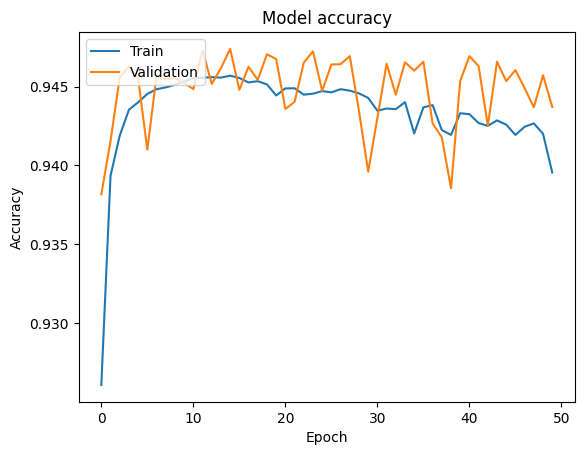

<Figure size 640x480 with 0 Axes>

In [30]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('acc_plo.jpg')

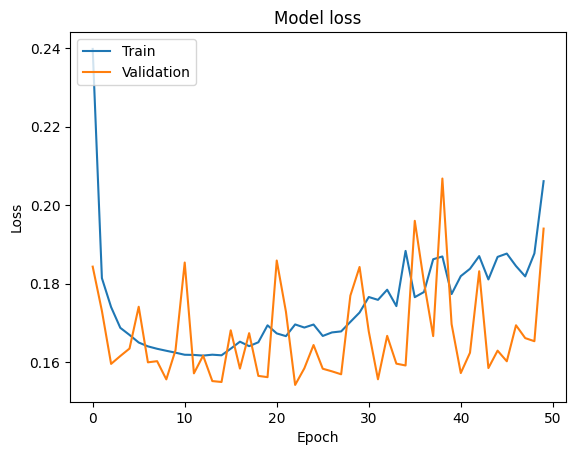

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('los_plo.jpg')

In [32]:
y_pred = model.predict(np.expand_dims(X_test, axis=2))

13871/13871 ━━━━━━━━━━━━━━━━━━━━ 103s 7ms/step


In [34]:
y_pred_classes = np.argmax(y_pred, axis=1)

# Inverse the 'attacks' dictionary to map back numbers to names
inverse_attacks = {v: k for k, v in attacks.items()}

# Generate the classification report with attack names instead of numbers
class_report = classification_report(y_test, y_pred_classes, target_names=[inverse_attacks[i] for i in range(len(inverse_attacks))])

print(class_report)

                       precision    recall  f1-score   support

               Normal       0.98      1.00      0.99    323305
                 MITM       1.00      0.29      0.44       263
            Uploading       0.70      0.43      0.53      7651
           Ransomware       0.82      0.79      0.81      2160
        SQL_injection       0.48      0.82      0.61     10100
            DDoS_HTTP       0.66      0.64      0.65     10117
             DDoS_TCP       0.92      0.94      0.93     10079
             Password       0.56      0.23      0.32      9971
        Port_Scanning       0.87      0.84      0.86      4514
Vulnerability_scanner       0.95      0.85      0.90      9941
             Backdoor       0.94      0.91      0.92      4891
                  XSS       0.89      0.06      0.12      3173
       Fingerprinting       1.00      0.21      0.35       182
             DDoS_UDP       1.00      1.00      1.00     24323
            DDoS_ICMP       1.00      1.00      1.00  

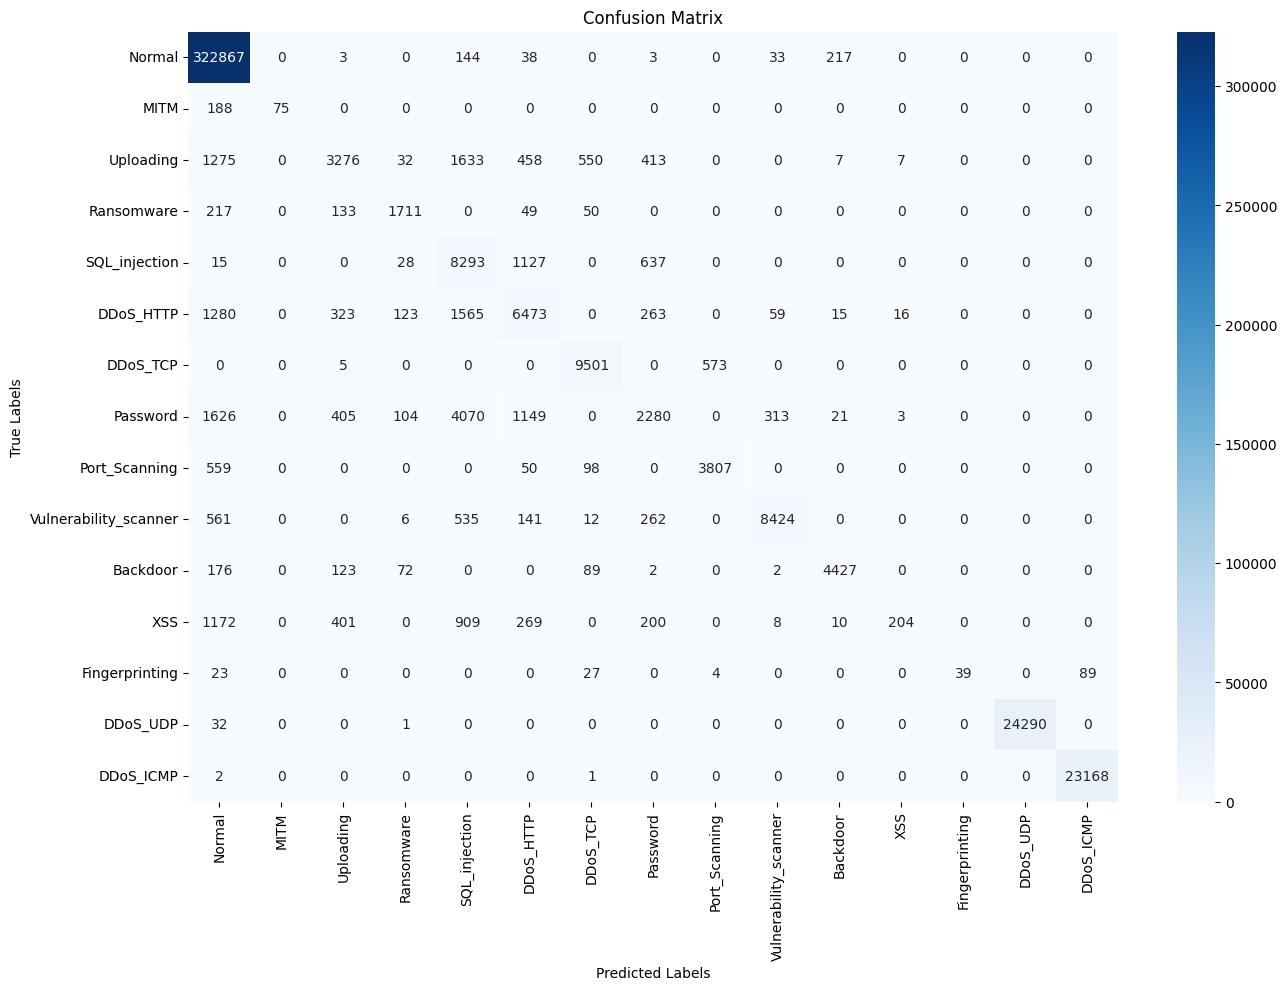

<Figure size 640x480 with 0 Axes>

In [35]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('con_mat.jpg')

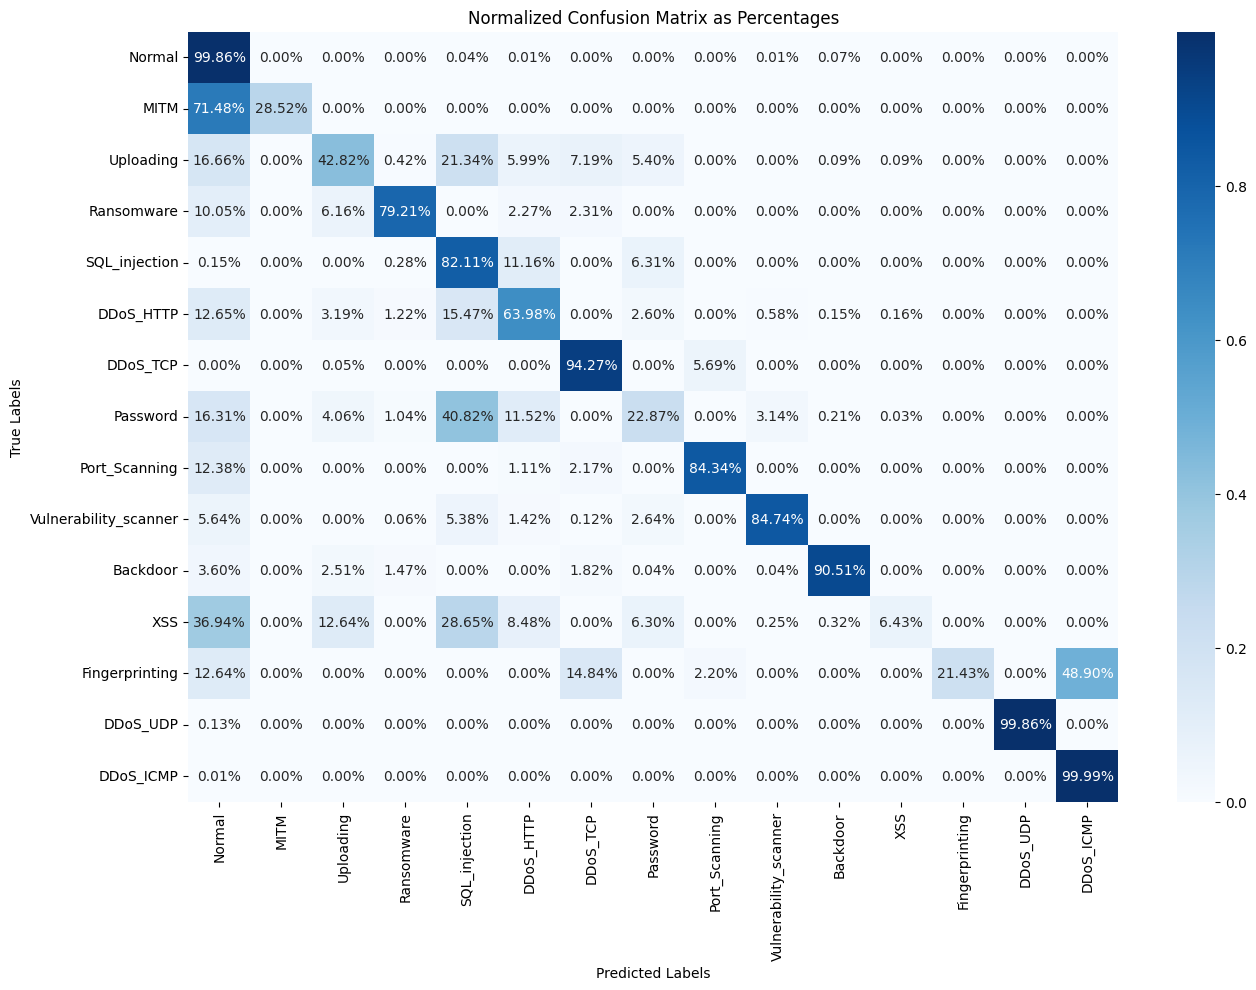

<Figure size 640x480 with 0 Axes>

In [36]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()
plt.savefig('con_per.jpg')